In [1]:
# Importaciones a usar en el analisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### Carga de Datos para Análisis de Expansión de Mercados

Se cargaron tres datasets clave para el análisis:

1. **\*Cultura (`hofstede.csv`)** → Contiene métricas culturales basadas en el modelo de Hofstede.
2. **\*Natalidad (`birth_rate.csv`)** → Proporciona tasas de natalidad por país.
3. **\*PIB (`world_bank_gdp.csv`)** → Contiene datos sobre el PIB de diferentes países.


In [2]:
df_cultura = pd.read_csv("hofstede.csv", delimiter=';')  
print(df_cultura.head())

df_natalidad = pd.read_csv("birth_rate.csv")
print(df_natalidad.head())

df_pib = pd.read_csv("./pib/world_bank_gdp.csv") 
print(df_pib.head())

   ctr      country     pdi     idv     mas     uai  ltowvs ivr
0  AFE  Africa East      64      27      41      52      32  40
1  AFW  Africa West      77      20      46      54       9  78
2  ALB      Albania  #NULL!  #NULL!  #NULL!  #NULL!      61  15
3  ALG      Algeria  #NULL!  #NULL!  #NULL!  #NULL!      26  32
4  AND      Andorra  #NULL!  #NULL!  #NULL!  #NULL!  #NULL!  65
      Entity Code         Day  Birth rate per day, on a monthly basis
0  Australia  AUS  1962-01-31                               59.827270
1  Australia  AUS  1962-02-28                               61.668243
2  Australia  AUS  1962-03-31                               62.976868
3  Australia  AUS  1962-04-30                               61.529507
4  Australia  AUS  1962-05-31                               61.744854
  Country Name Country Code                           Indicator Name  \
0        Aruba          ABW  PIB per cápita (US$ a precios actuales)   
1          NaN          AFE  PIB per cápita (US$ a p

### Se filtra y renombra columnas en el el los DataFrame y se extrae solo las columnas necesarias


In [3]:
df_cultura.rename(columns={
    'ctr': 'Country Code',
    'country': 'Country Name',
    'pdi': 'Power Distance',
    'idv': 'Individualism',
    'mas': 'Masculinity',
    'uai': 'Uncertainty Avoidance',
    'ltowvs': 'Long Term Orientation',
    'ivr': 'Indulgence'
}, inplace=True)

print(df_cultura.head())


  Country Code Country Name Power Distance Individualism Masculinity  \
0          AFE  Africa East             64            27          41   
1          AFW  Africa West             77            20          46   
2          ALB      Albania         #NULL!        #NULL!      #NULL!   
3          ALG      Algeria         #NULL!        #NULL!      #NULL!   
4          AND      Andorra         #NULL!        #NULL!      #NULL!   

  Uncertainty Avoidance Long Term Orientation Indulgence  
0                    52                    32         40  
1                    54                     9         78  
2                #NULL!                    61         15  
3                #NULL!                    26         32  
4                #NULL!                #NULL!         65  


In [4]:
df_natalidad_filtered = df_natalidad[['Entity', 'Code', 'Day', 'Birth rate per day, on a monthly basis']]

df_natalidad_filtered.rename(columns={
    'Entity': 'Country Name',
    'Code': 'Country Code',
    'Birth rate per day, on a monthly basis': 'Birth Rate'
}, inplace=True)

print(df_natalidad_filtered.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47243 entries, 0 to 47242
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  47243 non-null  object 
 1   Country Code  44615 non-null  object 
 2   Day           47243 non-null  object 
 3   Birth Rate    47243 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.4+ MB
None


In [5]:
df_pib_filtered = df_pib[['Country Name', 'Country Code', '2022']]

df_pib_filtered = df_pib_filtered.rename(columns={'2022': 'GDP per Capita'})


print(df_pib_filtered.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    266 non-null    object 
 2   GDP per Capita  255 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.4+ KB
None


In [6]:
# Unir PIB con Natalidad
df_merged = df_pib_filtered.merge(df_natalidad_filtered, on="Country Name", how="inner")

# Unir con Cultura (Hofstede)
df_merged = df_merged.merge(df_cultura, on="Country Name", how="inner")

# print(df_merged.sample(5))
print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6372 entries, 0 to 6371
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country Name           6372 non-null   object 
 1   Country Code_x         6372 non-null   object 
 2   GDP per Capita         6372 non-null   float64
 3   Country Code_y         6372 non-null   object 
 4   Day                    6372 non-null   object 
 5   Birth Rate             6372 non-null   float64
 6   Country Code           6372 non-null   object 
 7   Power Distance         6372 non-null   object 
 8   Individualism          6372 non-null   object 
 9   Masculinity            6372 non-null   object 
 10  Uncertainty Avoidance  6372 non-null   object 
 11  Long Term Orientation  6372 non-null   object 
 12  Indulgence             6372 non-null   object 
dtypes: float64(2), object(11)
memory usage: 647.3+ KB
None


In [7]:
# Convertir la columna de fecha a datetime para análisis temporal
df_merged['Day'] = pd.to_datetime(df_merged['Day'])

# Agrupar por país y calcular métricas clave
df_final = df_merged.groupby("Country Name").agg({
    "GDP per Capita": "mean",  # Promedio del PIB
    "Birth Rate": "sum",       # Total de nacimientos en el periodo
    "Power Distance": "first", 
    "Individualism": "first", 
    "Masculinity": "first", 
    "Uncertainty Avoidance": "first", 
    "Long Term Orientation": "first", 
    "Indulgence": "first"
}).reset_index()

# Convertir datos culturales a numéricos
cols_cultura = ["Power Distance", "Individualism", "Masculinity", "Uncertainty Avoidance", "Long Term Orientation", "Indulgence"]
df_final[cols_cultura] = df_final[cols_cultura].apply(pd.to_numeric, errors="coerce")

print(df_final)


  Country Name  GDP per Capita    Birth Rate  Power Distance  Individualism  \
0    Australia    64997.013654  30197.912681              38             90   
1      Austria    52176.664914  49368.817509              11             55   
2     Bulgaria    13644.201583  45471.193397              70             30   
3        Chile    15451.131958  41049.899085              63             23   
4      Estonia    28451.147783  26117.596409              40             60   
5       Israel    54930.726160  21617.492339              13             54   
6     Portugal    24620.519557  69314.567226              63             27   

   Masculinity  Uncertainty Avoidance  Long Term Orientation  Indulgence  
0           61                     51                     21        71.0  
1           79                     70                     60        63.0  
2           40                     85                     69        16.0  
3           28                     86                     31       

Se integraron datos de natalidad, PIB per cápita y dimensiones culturales de Hofstede para evaluar cada país según su potencial de crecimiento y estabilidad económica.

Para cada país, se calculó una puntuación basada en:

- **PIB per cápita**: Indica la capacidad económica de los habitantes.
- **Tasa de natalidad**: Representa el crecimiento demográfico y la demanda futura.
- **Individualismo**: Alta puntuación sugiere mercados con consumidores más independientes.
- **Evasión de la incertidumbre**: Baja puntuación indica mayor apertura al cambio y nuevos negocios.

Se asignaron pesos a estos factores para obtener una **puntuación final**, permitiendo ordenar los países según su atractivo para la expansión.

### Resultados

Los países con mejor puntuación presentan un equilibrio entre alta capacidad económica, crecimiento poblacional y apertura cultural, lo que los hace ideales para la expansión empresarial.


In [ ]:
# Normalizar variables numéricas
scaler = MinMaxScaler()
df_final[['GDP Score', 'Birth Rate Score']] = scaler.fit_transform(df_final[['GDP per Capita', 'Birth Rate']])

# Crear un índice ponderado
df_final["Market Potential Score"] = (
    df_final["GDP Score"] * 0.4 +  # PIB representa 40% del puntaje
    df_final["Birth Rate Score"] * 0.3 +  # Natalidad representa 30%
    df_final["Individualism"] * 0.2 / 100 +  # Cultura individualista favorece negocios
    (1 - df_final["Uncertainty Avoidance"] / 100) * 0.1  # Menor evasión a la incertidumbre favorece la inversión
)

# Ordenar por mejor puntuación
df_final = df_final.sort_values(by="Market Potential Score", ascending=False)


C:\Users\braya\AppData\Local\Temp\ipykernel_16868\2638543479.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final.head(10), x='Country Name', y='Market Potential Score', palette='viridis')


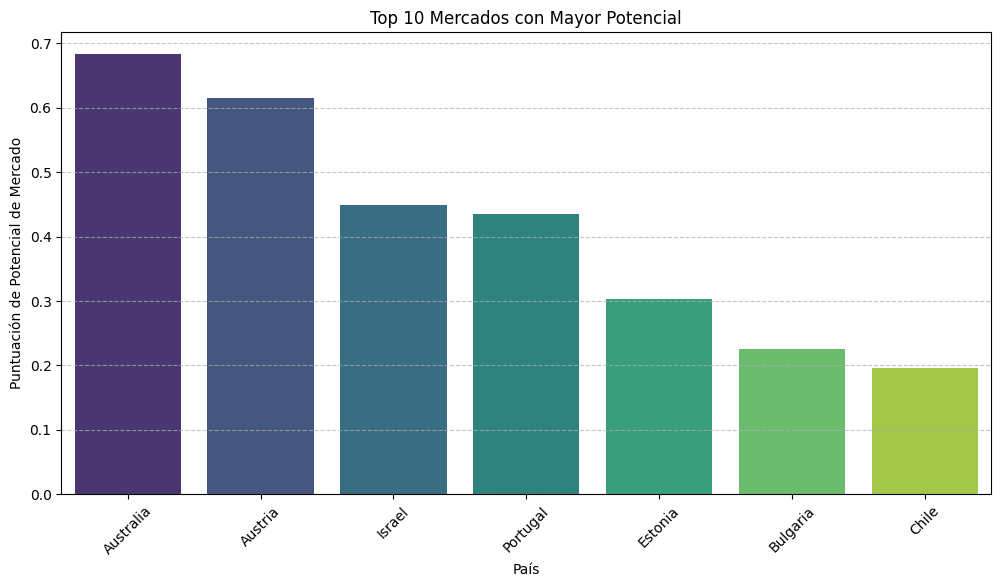

In [9]:

plt.figure(figsize=(12, 6))
sns.barplot(data=df_final.head(10), x='Country Name', y='Market Potential Score', palette='viridis')
plt.title("Top 10 Mercados con Mayor Potencial")
plt.xlabel("País")
plt.ylabel("Puntuación de Potencial de Mercado")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
